In [47]:
%load_ext autoreload
%autoreload 2
#!pip install tifffile
#!pip install scikit-image
from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
from tqdm import tqdm

from framework.dataset_modified import LandCoverData as LCD
from framework.dataset_modified import parse_image, load_image_train, load_image_test, numpy_parse_image


import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread

from weighted_loss import loss as weighted_categorical_cross_entropy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_FOLDER_STR = '/home/homer/Documents/Master_Statistique/Apprentissage_automatique/challenge/benchmark/challenge-ens/data'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
# path to the unzipped dataset: contains directories train/ and test/
DATASET_FOLDER = DATA_FOLDER/'dataset'

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
# get all test images
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))

In [3]:
def load_image_mask(image_path) :
    mask_path = image_path.parent.parent/'masks'/image_path.name
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        mask = mask[..., None]
    return image, mask

def compute_distribution(mask) :
    count = np.bincount(mask.ravel(), minlength=10)
    distrib = count/sum(count)
    return np.array(distrib)

def load_distributions(paths, n_max=1000) :
    ditributions = []
    for path in tqdm(paths):
        _, mask = load_image_mask(path)
        distrib = compute_distribution(mask)
        ditributions.append(distrib)
    return np.array(ditributions)

In [4]:
image_filenames_test = np.array([DATA_FOLDER_STR + '/dataset/test/images/' + path.name for path in test_images_paths])

In [5]:
train_filenames, val_filenames = train_test_split(train_images_paths, test_size=0.25)

In [6]:
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
    def __init__(self, image_filenames, batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size
    
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        return np.array([self.load_image(file_name) for file_name in batch_x])/255.0, np.array([self.load_mask(file_name) for file_name in batch_x])
    
    def load_image(self, image_path, channels=3) :
        mask_path = image_path.parent.parent/'masks'/image_path.name
        with TiffFile(image_path) as tifi :
            image = tifi.asarray()[:,:,:channels]
        return image
    
    def load_mask(self, image_path):
        mask_path = image_path.parent.parent/'masks'/image_path.name
        with TiffFile(mask_path) as tifm :
            mask = tifm.asarray()
        return mask
    
class My_Custom_Generator_test(tf.keras.utils.Sequence) :
  
    def __init__(self, image_filenames, batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size
    
    
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        return np.array([self.load_image(file_name) for file_name in batch_x])/255.0
    
    def load_image(self, image_path, channels=3) :
        with TiffFile(image_path) as tifi :
            image = tifi.asarray()[:,:,:channels]
        return image

In [7]:
batch_size=8
train_generator = My_Custom_Generator(train_filenames, batch_size)
val_generator = My_Custom_Generator(val_filenames, batch_size)

In [8]:
test_generator = My_Custom_Generator_test(image_filenames_test, 1)

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [11]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [52]:
OUTPUT_CLASSES = 10
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [53]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 96 1841984     input_9[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 512)  1476608     model[7][4]                      
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 16, 16, 1088) 0           sequential[7][0]                 
                                                                 model[7][3]                

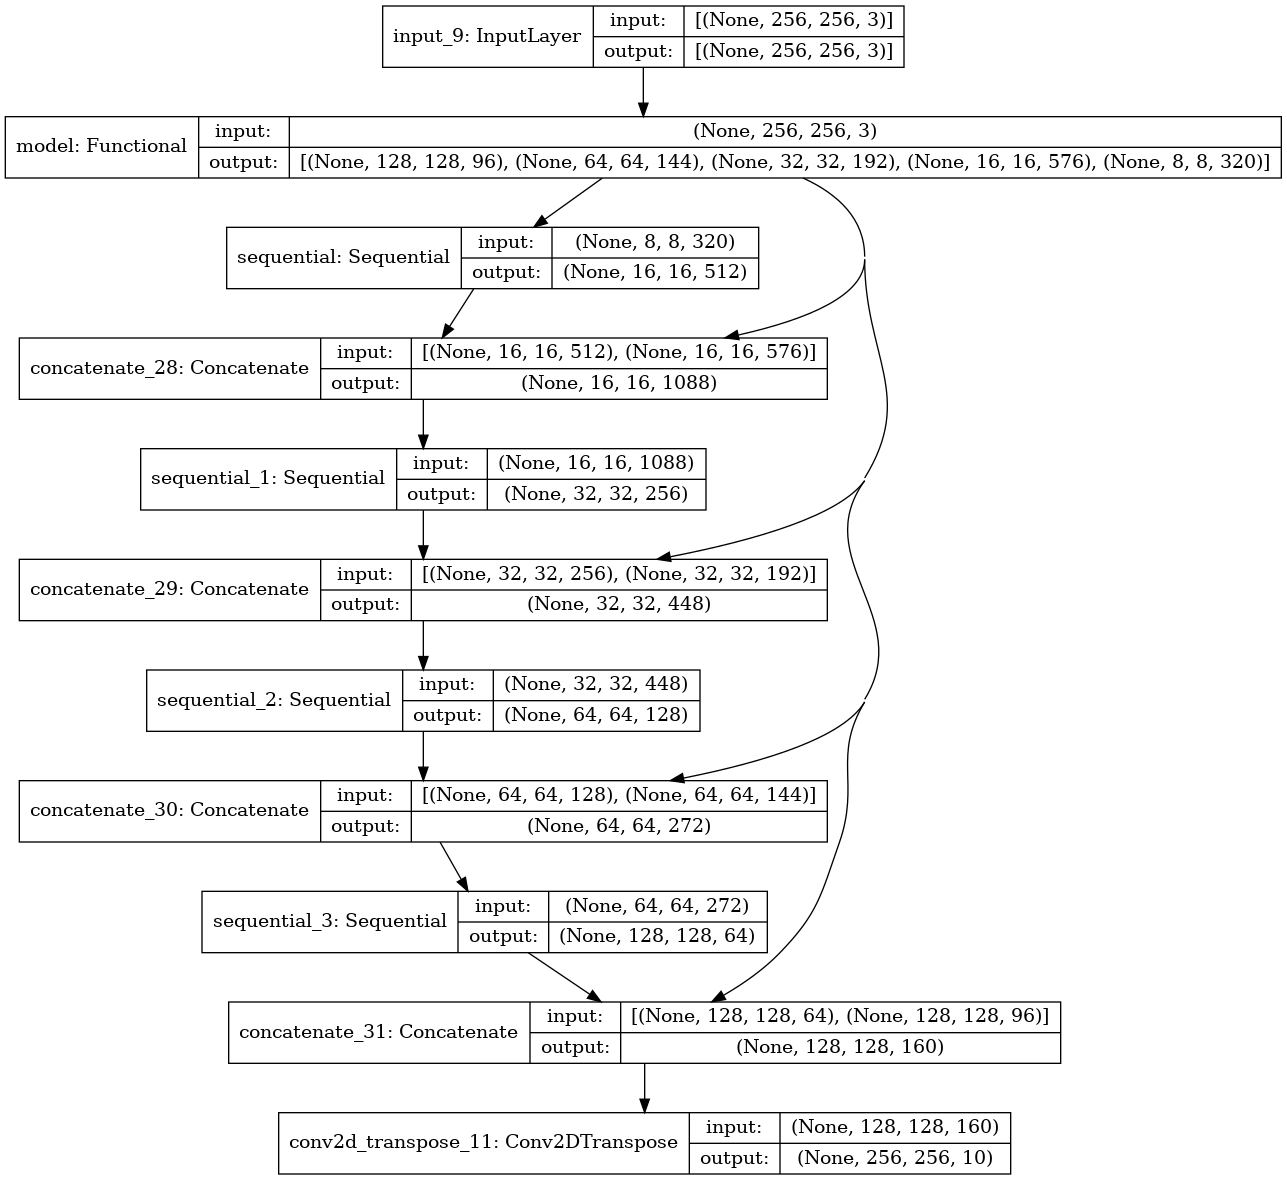

In [54]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [51]:
hist = model.fit_generator(generator=train_generator,
                   steps_per_epoch = int(len(train_filenames) // batch_size),
                   epochs = 30,
                   verbose = 1,
                   validation_data = val_generator,
                   validation_steps = int(len(val_filenames) // batch_size),
                   #class_weight = class_weight
                    )

/home/homer/.local/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30


RuntimeError: in user code:

    /home/homer/.local/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /home/homer/Documents/Master_Statistique/Apprentissage_automatique/challenge/benchmark/challenge-ens/weighted_loss.py:63 loss  *
        _validate_rank(labels, predictions, weights)
    /home/homer/Documents/Master_Statistique/Apprentissage_automatique/challenge/benchmark/challenge-ens/weighted_loss.py:31 _validate_rank  *
        raise RuntimeError(

    RuntimeError: Weight and label tensors were not of the same rank. weights.shape was (None, 256, 256, 10), and labels.shape was (None, None, None).


* **Epoch 1** : En envrion 40 min on a : 
   * *train* $\rightarrow$ accuracy=0.6527, loss=0.8324
   * *test* $\rightarrow$ accuracy=0.65, loss=0.8330

In [16]:
def predict_as_vectors(model, dataset, steps=None):
    """Perform a forward pass over the dataset and bincount the prediction masks to return class vectors.
    Args:
        model (tf.keras.Model): model
        dataset (tf.data.Dataset): dataset to perform inference on
        steps (int, optional): the total number of steps (batches) in the dataset, used for the progress bar
    Returns:
        (pandas.DataFrame): predicted class distribution vectors for the dataset
    """
    def bincount_along_axis(arr, minlength=None, axis=-1):
        """Bincounts a tensor along an axis"""
        if minlength is None:
            minlength = tf.reduce_max(arr) + 1
        mask = tf.equal(arr[..., None], tf.range(minlength, dtype=arr.dtype))
        return tf.math.count_nonzero(mask, axis=axis-1 if axis < 0 else axis)

    predictions = []
    for batch in tqdm(dataset, total=steps):
        # predict a raster for each sample in the batch
        pred_raster = model.predict_on_batch(batch)

        (batch_size, _, _, num_classes) = tuple(pred_raster.shape)
        pred_mask = tf.argmax(pred_raster, -1) # (bs, 256, 256)
        # bincount for each sample
        counts = bincount_along_axis(
            tf.reshape(pred_mask, (batch_size, -1)), minlength=num_classes, axis=-1
        )
        predictions.append(counts / tf.math.reduce_sum(counts, -1, keepdims=True))

    predictions = tf.concat(predictions, 0)
    return predictions.numpy()


In [17]:
predictions = predict_as_vectors(model, test_generator)

100%|██████████| 5043/5043 [12:51<00:00,  6.53it/s]


In [21]:
N = len(image_filenames_test)
predictions_final = np.c_[ np.zeros(N), predictions[:,0:7], np.zeros(N), predictions[:,7] ]
import pandas as pd
df = pd.DataFrame(predictions_final, columns=['no_data', 'clouds','artificial','cultivated','broadleaf','coniferous','herbaceous','natural','snow','water'])
df.to_csv('results/unet_mvnet/result1.csv')